<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Author: [Yury Kashnitsky](https://www.linkedin.com/in/festline/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

## <center> Assignment 4 (demo)
### <center>  Sarcasm detection with logistic regression
    
**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit) + [solution](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution).**


We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../../data/input/sarcasm/

test-balanced.csv  test-unbalanced.csv	train-balanced-sarcasm.csv


In [216]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [47]:
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)
setattr(pd.Series,'ends',ends)

In [3]:
df = pd.read_csv('../../data/input/sarcasm/train-balanced-sarcasm.csv')
df = df.copy().sample(frac=1, random_state=17).reset_index(drop=True);

In [4]:
df.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,"Good thing Soros is so rich, these guys must b...",zaures,politics,7,-1,-1,2016-11,2016-11-16 02:12:37,Anti-Trump protests not letting up for sixth s...
1,0,I'm also not being able to send NZB files from...,pienocake,usenet,1,1,0,2016-03,2016-03-17 03:23:56,Congratulations! SAB has always been a great p...
2,1,Or Kanye West?,griffin852,Monstercat,2,2,0,2014-08,2014-08-13 00:10:39,Or Concept?
3,0,Fuck.,EL_SUPER_BEASTO,Flyers,3,3,0,2014-01,2014-01-15 23:55:51,Hartnell listed as day to day after blocking shot
4,0,"I think the suit does have some tech in it, si...",zoahporre,movies,2,2,0,2016-02,2016-02-11 18:44:38,"Ok, so either Batman's *normal* suit has some ..."
5,0,"The way I see it, experiences in real life are...",sheggorath,AskReddit,2,2,0,2013-04,2013-04-29 17:24:12,I've never had any experience in real life I e...
6,0,You can't say that and not include your steam ...,ConfirmedSFW,Monstercat,6,6,0,2016-01,2016-01-01 00:06:21,Hook me up on Steam guys!
7,0,I wonder if she will regret those piercings wh...,Quixilver05,trashy,7,7,0,2016-02,2016-02-24 22:02:55,Seems to me she should spend less time on pier...
8,1,I'm saying both you and John Legend are Hitler...,harrison5394,hiphopheads,0,0,0,2016-01,2016-01-21 16:00:08,"I don't follow politics, so I'm not sure what ..."
9,1,"This really looks like ""draining the swamp""",DrPepsiJamBlast,politics,0,-1,-1,2016-11,2016-11-18 16:44:34,Trump Picks Sen. Jeff Sessions For Attorney Ge...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [15]:
df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [16]:
df['comment_length'] = df['comment'].map(lambda x: len(x))
df['label_str'] = df['label'].map({1: 'sarcastic', 0: 'normal'})

In [17]:
df.describe()

,label,score,ups,downs,comment_length
count,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06
mean,4.999817e-01,6.885999e+00,5.499140e+00,-1.458686e-01,5.669230e+01
std,5.000002e-01,4.834411e+01,4.127402e+01,3.529746e-01,6.182128e+01
min,0.000000e+00,-5.070000e+02,-5.070000e+02,-1.000000e+00,1.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.700000e+01
50%,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,4.600000e+01
75%,1.000000e+00,4.000000e+00,3.000000e+00,0.000000e+00,7.400000e+01
max,1.000000e+00,9.070000e+03,5.163000e+03,0.000000e+00,1.000000e+04


In [18]:
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

In [19]:
def log_transform_col(col):
    df['log2p_' + col] = df[col].map(lambda x: np.sign(x) * np.log2(1 + np.abs(x)));
    
def log_transform(cols):
    for col in cols:
        log_transform_col(col);

In [20]:
log_transform(['score', 'ups', 'downs', 'comment_length'])

In [21]:
df.describe()

,label,score,ups,downs,comment_length,log2p_score,log2p_ups,log2p_downs,log2p_comment_length
count,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06,1.010773e+06
mean,4.999817e-01,6.885999e+00,5.499140e+00,-1.458686e-01,5.669230e+01,1.655088e+00,1.242480e+00,-1.458686e-01,5.456578e+00
std,5.000002e-01,4.834411e+01,4.127402e+01,3.529746e-01,6.182128e+01,1.678296e+00,1.809320e+00,3.529746e-01,1.124551e+00
min,0.000000e+00,-5.070000e+02,-5.070000e+02,-1.000000e+00,1.000000e+00,-8.988685e+00,-8.988685e+00,-1.000000e+00,1.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.700000e+01,1.000000e+00,0.000000e+00,0.000000e+00,4.807355e+00
50%,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,4.600000e+01,1.584963e+00,1.000000e+00,0.000000e+00,5.554589e+00
75%,1.000000e+00,4.000000e+00,3.000000e+00,0.000000e+00,7.400000e+01,2.321928e+00,2.000000e+00,0.000000e+00,6.228819e+00
max,1.000000e+00,9.070000e+03,5.163000e+03,0.000000e+00,1.000000e+04,1.314705e+01,1.233427e+01,0.000000e+00,1.328786e+01


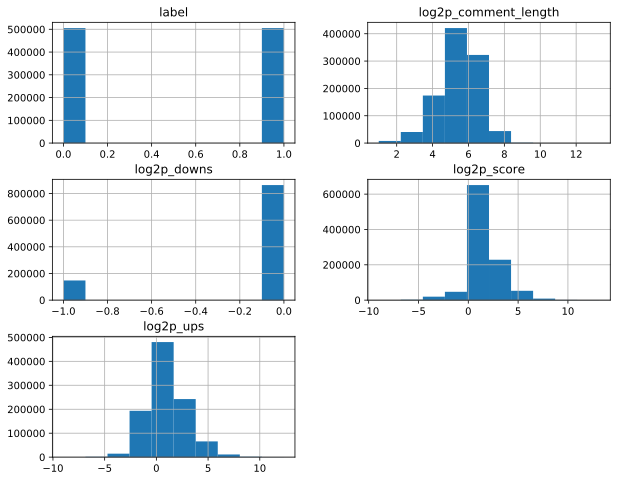

In [22]:
df[['label', 'log2p_score', 'log2p_ups', 'log2p_downs', 'log2p_comment_length']].hist(figsize=(10, 8))

In [30]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 8))
sns.boxplot(x='label_str', y='log2p_comment_length', data=df, ax=axes[0])
sns.violinplot(x='label_str', y='log2p_comment_length', data=df, ax=axes[1]);

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [24]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

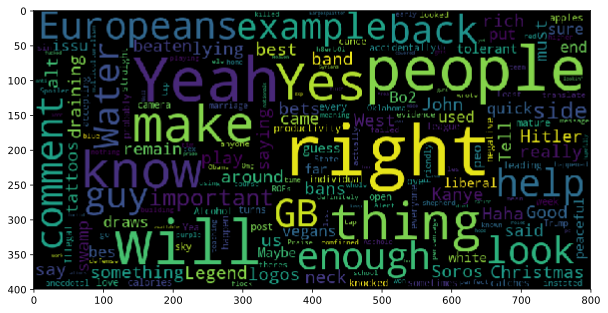

In [25]:
plt.figure(figsize=(10, 8))
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.imshow(wordcloud);

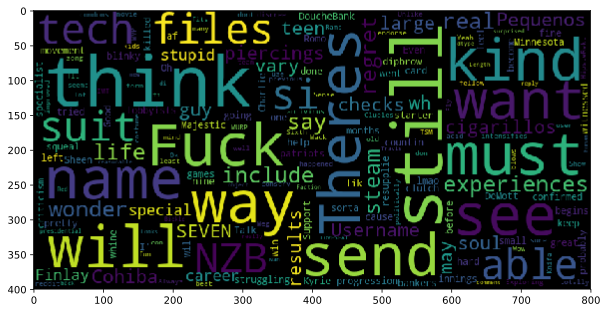

In [26]:
plt.figure(figsize=(10, 8))
wordcloud.generate(str(df.loc[df['label'] == 0, 'comment']))
plt.imshow(wordcloud);

In [27]:
sub_df = df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [28]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [32]:
y = df['label']
X = df.drop('label', axis=1).drop('label_str', axis=1)

In [37]:
y.head(5)

0    1
1    0
2    1
3    0
4    0
Name: label, dtype: int64

In [38]:
X.head(5)

,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_length,log2p_score,log2p_ups,log2p_downs,log2p_comment_length
0,"Good thing Soros is so rich, these guys must b...",zaures,politics,7,-1,-1,2016-11,2016-11-16 02:12:37,Anti-Trump protests not letting up for sixth s...,77,3.000000,-1.000000,-1.0,6.285402
1,I'm also not being able to send NZB files from...,pienocake,usenet,1,1,0,2016-03,2016-03-17 03:23:56,Congratulations! SAB has always been a great p...,70,1.000000,1.000000,0.0,6.149747
2,Or Kanye West?,griffin852,Monstercat,2,2,0,2014-08,2014-08-13 00:10:39,Or Concept?,14,1.584963,1.584963,0.0,3.906891
3,Fuck.,EL_SUPER_BEASTO,Flyers,3,3,0,2014-01,2014-01-15 23:55:51,Hartnell listed as day to day after blocking shot,5,2.000000,2.000000,0.0,2.584963
4,"I think the suit does have some tech in it, si...",zoahporre,movies,2,2,0,2016-02,2016-02-11 18:44:38,"Ok, so either Batman's *normal* suit has some ...",77,1.584963,1.584963,0.0,6.285402


In [59]:
from sklearn import metrics

def report(classifier, X, y):
    y_pred = classifier.predict(X)
    report = metrics.classification_report(y, y_pred)
        
    print(report)
    print(metrics.accuracy_score(y, y_pred))
    
def visualize_coefficients(classifier, feature_names, n=25):
    coef = classifier.coef_.ravel()
    idx = np.argsort(coef)
    neg_idx = idx[:n]
    pos_idx = idx[-n:]
    top_idx = np.hstack([neg_idx, pos_idx])
    
    plt.figure(figsize=(12, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_idx]]
    plt.bar(np.arange(len(top_idx)), coef[top_idx], color=colors)
    
    feature_names=np.array(feature_names)
    plt.xticks(np.arange(len(top_idx)), feature_names[top_idx], rotation=60, fontsize=7)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [96]:
%%time

pipe = make_pipeline(\
    TfidfVectorizer(ngram_range=(1,1), max_features=10000),       \
    LogisticRegression(solver='lbfgs', n_jobs=1, random_state=17) \
)

pipe.fit(X_train['comment'], y_train);

CPU times: user 51.7 s, sys: 1.11 s, total: 52.8 s
Wall time: 19 s


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [97]:
pipe.named_steps

{'tfidfvectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=10000, min_df=1,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=1,
           penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
           verbose=0, warm_start=False)}

In [98]:
vectorizer = pipe.named_steps['tfidfvectorizer']
logit = pipe.named_steps['logisticregression']

In [99]:
features = vectorizer.get_feature_names()
pd.Series(features).ends(10)

0             00
1            000
2       00100000
3             01
4             05
5             06
6             07
7             08
8             10
9            100
9990       ziggo
9991        zijn
9992     zionist
9993         zip
9994      zombie
9995     zombies
9996        zone
9997       zones
9998         zoo
9999        zoom
dtype: object

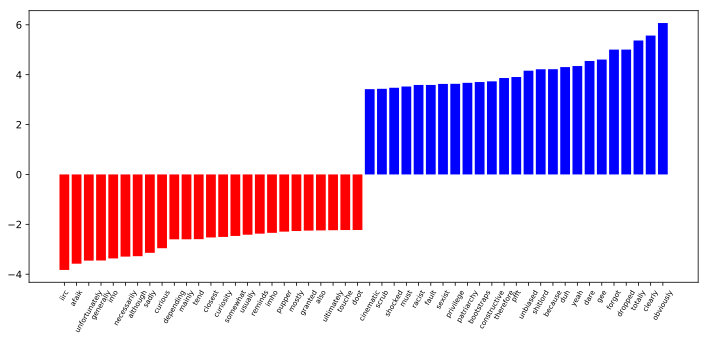

In [100]:
visualize_coefficients(logit, features)

In [101]:
report(pipe, X_test['comment'], y_test)

              precision    recall  f1-score   support

           0       0.68      0.73      0.70    126365
           1       0.71      0.65      0.68    126329

   micro avg       0.69      0.69      0.69    252694
   macro avg       0.69      0.69      0.69    252694
weighted avg       0.69      0.69      0.69    252694

0.691053210602547


In [102]:
# ---------------------------------------------------------------------------------------

In [113]:
%%time

pipe = make_pipeline(\
    TfidfVectorizer(ngram_range=(1,2), max_features=10000),       \
    LogisticRegression(solver='lbfgs', n_jobs=1, random_state=17) \
)

pipe.fit(X_train['comment'], y_train);

CPU times: user 1min 15s, sys: 1.75 s, total: 1min 17s
Wall time: 40.9 s


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [114]:
pipe.named_steps

{'tfidfvectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=10000, min_df=1,
         ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=1,
           penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
           verbose=0, warm_start=False)}

In [115]:
vectorizer = pipe.named_steps['tfidfvectorizer']
logit = pipe.named_steps['logisticregression']

In [116]:
features = vectorizer.get_feature_names()
pd.Series(features).ends(10)

0                00
1               000
2                10
3             10 10
4        10 minutes
5          10 years
6               100
7            100 of
8              1000
9              1050
9990          youth
9991        youtube
9992            yup
9993          zelda
9994           zero
9995          ziggo
9996    ziggo ziggo
9997         zombie
9998        zombies
9999           zone
dtype: object

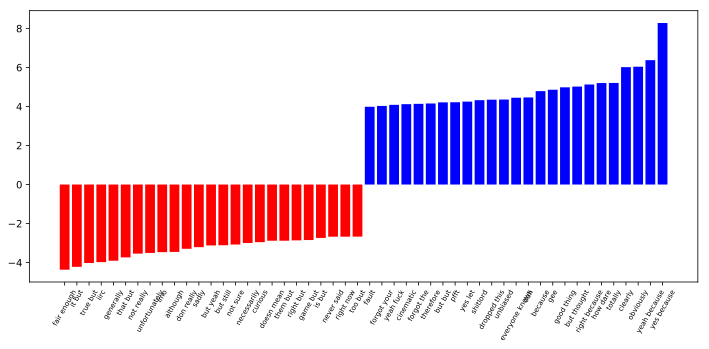

In [117]:
visualize_coefficients(logit, features)

In [118]:
report(pipe, X_test['comment'], y_test)

              precision    recall  f1-score   support

           0       0.69      0.75      0.72    126365
           1       0.73      0.66      0.69    126329

   micro avg       0.71      0.71      0.71    252694
   macro avg       0.71      0.71      0.71    252694
weighted avg       0.71      0.71      0.71    252694

0.7079075878335062


In [119]:
import eli5
eli5.show_weights(pipe, top=30)

Weight?,Feature
+8.278,yes because
+6.374,yeah because
+6.038,obviously
+6.016,clearly
+5.207,totally
+5.201,how dare
+5.126,right because
+5.020,but thought
+4.982,good thing
+4.858,gee


In [120]:
eli5.show_weights(logit, vec=vectorizer, top=30)

Weight?,Feature
+8.278,yes because
+6.374,yeah because
+6.038,obviously
+6.016,clearly
+5.207,totally
+5.201,how dare
+5.126,right because
+5.020,but thought
+4.982,good thing
+4.858,gee


In [127]:
for i in [1,2,3,4,5]:
    print('True label: %s' % y_train.iloc[i])
    display(eli5.show_prediction(logit, X_train['comment'].iloc[i], vec=vectorizer))

True label: 1


True label: 1


True label: 0


True label: 0


True label: 1


In [109]:
# ---------------------------------------------------------------------------------------

In [110]:
%%time

pipe = make_pipeline(\
    HashingVectorizer(ngram_range=(1,2)),       \
    SGDClassifier(loss='log', n_jobs=1, random_state=17) \
)

pipe.fit(X_train['comment'], y_train);

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


CPU times: user 15.3 s, sys: 90 ms, total: 15.4 s
Wall time: 15.5 s


In [111]:
vectorizer = pipe.named_steps['hashingvectorizer']
logit = pipe.named_steps['sgdclassifier']

In [112]:
report(pipe, X_test['comment'], y_test)

              precision    recall  f1-score   support

           0       0.65      0.75      0.69    126365
           1       0.70      0.59      0.64    126329

   micro avg       0.67      0.67      0.67    252694
   macro avg       0.67      0.67      0.67    252694
weighted avg       0.67      0.67      0.67    252694

0.6702137763460945


In [ ]:
# ---------------------------------------------------------------------------------------

In [217]:
transformer = FeatureUnion([
    ('comment_tfidf', Pipeline(
        [
            ('extract_field', FunctionTransformer(lambda x: x['comment'], validate=False)),
            ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000))
        ]
    )),
    ('subreddit_vec', Pipeline(
        [
            ('extract_field', FunctionTransformer(lambda x: x['subreddit'], validate=False)),
            ('tfidf', TfidfVectorizer(ngram_range=(1,1)))
        ]
    ))
])

In [218]:
%%time

pipe = make_pipeline(\
    transformer,       \
    LogisticRegressionCV(solver='lbfgs', n_jobs=1, random_state=17) \
)

pipe.fit(X_train, y_train);

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase t

CPU times: user 27min 6s, sys: 11min 38s, total: 38min 45s
Wall time: 5min 24s


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [219]:
pipe.named_steps

{'featureunion': FeatureUnion(n_jobs=None,
        transformer_list=[('comment_tfidf', Pipeline(memory=None,
      steps=[('extract_field', FunctionTransformer(accept_sparse=False, check_inverse=True,
           func=<function <lambda> at 0x7ff5354bbbf8>, inv_kw_args=None,
           inverse_func=None, kw_args=None, pass_y='deprecated',
           valid...      token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None))]))],
        transformer_weights=None),
 'logisticregressioncv': LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='warn', n_jobs=1, penalty='l2', random_state=17,
            refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)}

In [220]:
transformers = dict(pipe.named_steps['featureunion'].transformer_list)
features1 = dict(transformers['comment_tfidf'].steps)['tfidf'].get_feature_names()
features2 = dict(transformers['subreddit_vec'].steps)['tfidf'].get_feature_names()

features = np.concatenate((features1, features2))
pd.Series(features).ends(20)

0                           00
1                          000
2                           10
3                        10 10
4                   10 minutes
5                     10 years
6                          100
7                       100 of
8                         1000
9                         1050
10               1050 founders
11                        1060
12                   1060 1050
13                        1070
14                   1070 1060
15                        1080
16                   1080 1070
17                       1080p
18                          11
19                          12
23213              zodiacfalls
23214                 zoidberg
23215                    zoids
23216                   zoloft
23217                 zombidle
23218              zombiemanic
23219                  zombies
23220         zombiesurvivalrp
23221    zombiesurvivaltactics
23222                   zomboy
23223           zooeydeschanel
23224          zookeeperbattle
23225   

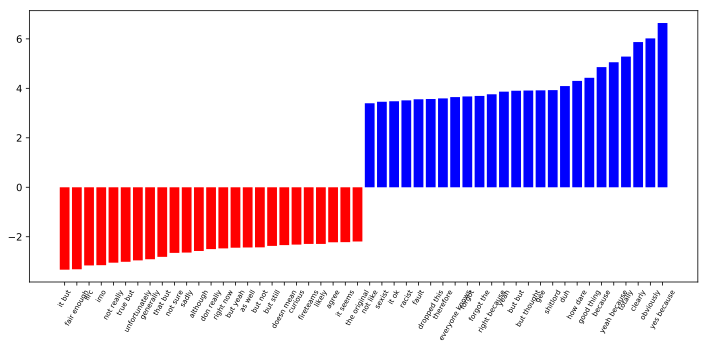

In [222]:
logit = pipe.named_steps['logisticregressioncv']
visualize_coefficients(logit, features)

In [223]:
report(pipe, X_test, y_test)

              precision    recall  f1-score   support

           0       0.70      0.75      0.73    126365
           1       0.73      0.68      0.70    126329

   micro avg       0.71      0.71      0.71    252694
   macro avg       0.72      0.71      0.71    252694
weighted avg       0.72      0.71      0.71    252694

0.7142195699146002


## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions